# ML Pipeline 

In [1]:
import os
current_dir = os.getcwd()
current_dir

'/Users/allaafaham/Library/Mobile Documents/com~apple~CloudDocs/cursor projects/house-prices/notebooks'

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


In [3]:
current_dir = os.getcwd()
current_dir

'/Users/allaafaham/Library/Mobile Documents/com~apple~CloudDocs/cursor projects/house-prices'

# Load data

In [4]:
import pandas as pd


# Read the dataset
df = pd.read_csv("outputs/datasets/collection/house_prices_records.csv")

# Display basic information
print("Dataset Shape:", df.shape)
print("\nDataset Info:")
df.shape
df.info()



Dataset Shape: (1460, 24)

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 24 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   1stFlrSF       1460 non-null   int64  
 1   2ndFlrSF       1374 non-null   float64
 2   BedroomAbvGr   1361 non-null   float64
 3   BsmtExposure   1422 non-null   object 
 4   BsmtFinSF1     1460 non-null   int64  
 5   BsmtFinType1   1315 non-null   object 
 6   BsmtUnfSF      1460 non-null   int64  
 7   EnclosedPorch  136 non-null    float64
 8   GarageArea     1460 non-null   int64  
 9   GarageFinish   1225 non-null   object 
 10  GarageYrBlt    1379 non-null   float64
 11  GrLivArea      1460 non-null   int64  
 12  KitchenQual    1460 non-null   object 
 13  LotArea        1460 non-null   int64  
 14  LotFrontage    1201 non-null   float64
 15  MasVnrArea     1452 non-null   float64
 16  OpenPorchSF    1460 non-null   int64  
 17  OverallCond

In [5]:
# split

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(['SalePrice'], axis=1),
    df['SalePrice'],
    test_size=0.2,
    random_state=0,
)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(1168, 23) (1168,) (292, 23) (292,)


In [6]:
import warnings
# Suppress FutureWarning from pandas for is_categorical_dtype
warnings.filterwarnings(
    "ignore",
    category=FutureWarning,
    message="is_categorical_dtype is deprecated.*",
    module="pandas.*"
)

import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from feature_engine.imputation import MeanMedianImputer, CategoricalImputer, ArbitraryNumberImputer
from feature_engine.encoding import OrdinalEncoder
from feature_engine.transformation import YeoJohnsonTransformer, LogTransformer
from feature_engine.selection import DropFeatures

    
def create_full_preprocessing_pipeline(model):
    # Custom function to apply square root transformation to specific column
   

    pipeline = Pipeline([
        # 1. Imputation
        ('impute_median', MeanMedianImputer(
            imputation_method='median',
            variables=['BedroomAbvGr', 'LotFrontage']
        )),

        ('impute_categorical', CategoricalImputer(
            imputation_method='missing',
            variables=['BsmtExposure', 'BsmtFinType1', 'GarageFinish']
        )),

        ('impute_zero', ArbitraryNumberImputer(
            arbitrary_number=0,
            variables=['2ndFlrSF', 'GarageYrBlt', 'MasVnrArea']
        )),

        # 2. Drop high-missingness features
        ('drop_features', DropFeatures(features_to_drop=['EnclosedPorch', 'WoodDeckSF'])),

        # 3. Encoding
        ('ordinal_encoder', OrdinalEncoder(
            encoding_method='arbitrary',
            variables=['BsmtExposure', 'BsmtFinType1', 'GarageFinish', 'KitchenQual']
        )),

        # 4. Transformations
        ('yeo_transform', YeoJohnsonTransformer(
            variables=['1stFlrSF', 'BedroomAbvGr', 'BsmtFinSF1', 'LotArea', 'LotFrontage', 'TotalBsmtSF']  # Removed 'SalePrice'
        )),

        ('log10_transform', LogTransformer(
            base='10',
            variables=['GrLivArea']
        )),

        # 5. Scaling
        ('scaler', StandardScaler()),

        # 6. Estimator
        ('model', model)
    ])

    return pipeline

# custom class for hyperparameter

In [7]:
from sklearn.model_selection import GridSearchCV


class HyperparameterOptimizationSearch:

    def __init__(self, models, params):
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, X, y, cv, n_jobs, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print(f"\nRunning GridSearchCV for {key} \n")

            model = create_full_preprocessing_pipeline(self.models[key])
            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs,
                              verbose=verbose, scoring=scoring, )
            gs.fit(X, y)
            self.grid_searches[key] = gs

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                'estimator': key,
                'min_score': min(scores),
                'max_score': max(scores),
                'mean_score': np.mean(scores),
                'std_score': np.std(scores),
            }
            return pd.Series({**params, **d})

        rows = []
        for k in self.grid_searches:
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                r = self.grid_searches[k].cv_results_[key]
                scores.append(r.reshape(len(params), 1))

            all_scores = np.hstack(scores)
            for p, s in zip(params, all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)
        columns = ['estimator', 'min_score',
                   'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]
        return df[columns], self.grid_searches

In [8]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor
import numpy as np

models_quick_search = {
    
   'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    'XGBRegressor': XGBRegressor(random_state=42),

}


params_quick_search = {
    "Linear Regression": {},
    "Decision Tree": {},
    "Random Forest": {},
    "Gradient Boosting": {},
    "XGBRegressor": {},
}

In [9]:
import warnings
import pandas as pd
from pandas.api.types import CategoricalDtype

# Your imports and pipeline code as above

# Run the search with warnings suppressed
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=FutureWarning, module="pandas")
    search = HyperparameterOptimizationSearch(models=models_quick_search, params=params_quick_search)
    search.fit(X_train, y_train, scoring='r2', n_jobs=-1, cv=5)


Running GridSearchCV for Linear Regression 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for Decision Tree 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for Random Forest 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for Gradient Boosting 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for XGBRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


In [10]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score
2,Random Forest,0.753456,0.850574,0.895728,0.054502
3,Gradient Boosting,0.658801,0.832731,0.900463,0.089002
4,XGBRegressor,0.712213,0.831798,0.89709,0.062847
0,Linear Regression,0.743422,0.826513,0.866301,0.044743
1,Decision Tree,0.582553,0.668812,0.804945,0.084164


### Do an extensive search on the most suitable model to find the best hyperparameter configuration.

In [11]:
# Define models (top 3 from previous results)
models_search = {
    'Random Forest': RandomForestRegressor(random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    'XGBRegressor': XGBRegressor(random_state=42),
}

# Define hyperparameter grids for tuning
params_search = {
    'Random Forest': {
        'model__n_estimators': [100, 200, 300],
        'model__max_depth': [None, 10, 20],
        'model__min_samples_split': [2, 5],
        'model__min_samples_leaf': [1, 2]
    },
    'Gradient Boosting': {
        'model__n_estimators': [100, 200],
        'model__learning_rate': [0.01, 0.05, 0.1],
        'model__max_depth': [3, 5],
        'model__min_samples_split': [2, 5]
    },
    'XGBRegressor': {
        'model__n_estimators': [100, 200],
        'model__learning_rate': [0.01, 0.05, 0.1],
        'model__max_depth': [3, 5],
        'model__subsample': [0.8, 1.0]
    }
}

In [12]:
# Run the search with warning suppression
with warnings.catch_warnings():
    warnings.filterwarnings(
        "ignore",
        category=FutureWarning,
        message="is_categorical_dtype is deprecated.*",
        module="pandas.*"
    )
    search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
    search.fit(X_train, y_train, scoring='r2', n_jobs=-1, cv=5)


Running GridSearchCV for Random Forest 

Fitting 5 folds for each of 36 candidates, totalling 180 fits

Running GridSearchCV for Gradient Boosting 

Fitting 5 folds for each of 24 candidates, totalling 120 fits

Running GridSearchCV for XGBRegressor 

Fitting 5 folds for each of 24 candidates, totalling 120 fits


In [13]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score,model__max_depth,model__min_samples_leaf,model__min_samples_split,model__n_estimators,model__learning_rate,model__subsample
72,XGBRegressor,0.7466,0.859115,0.917302,0.060229,5,NaN,NaN,100,0.05,0.8
74,XGBRegressor,0.731606,0.858414,0.917244,0.066058,5,NaN,NaN,200,0.05,0.8
80,XGBRegressor,0.739246,0.855987,0.916268,0.061203,5,NaN,NaN,100,0.1,0.8
82,XGBRegressor,0.734959,0.854773,0.91752,0.062921,5,NaN,NaN,200,0.1,0.8
15,Random Forest,0.772695,0.853127,0.893495,0.046641,10,1,5,100,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
36,Gradient Boosting,0.624853,0.657537,0.701859,0.027633,3,NaN,2,100,0.01,NaN
65,XGBRegressor,-0.192035,-0.074335,-0.003241,0.071496,5,NaN,NaN,100,0.01,1.0
64,XGBRegressor,-0.199692,-0.080343,-0.017076,0.066645,5,NaN,NaN,100,0.01,0.8
61,XGBRegressor,-0.250041,-0.086096,-0.014334,0.085117,3,NaN,NaN,100,0.01,1.0


In [14]:

best_model = grid_search_summary.iloc[0, 0]
best_model


'XGBRegressor'

In [15]:
best_parameters = grid_search_pipelines[best_model].best_params_
best_parameters

{'model__learning_rate': 0.05,
 'model__max_depth': 5,
 'model__n_estimators': 100,
 'model__subsample': 0.8}

In [16]:
best_pipeline = grid_search_pipelines[best_model].best_estimator_
best_pipeline

,steps,"[('impute_median', ...), ('impute_categorical', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,imputation_method,'median'
,variables,"['BedroomAbvGr', 'LotFrontage']"
,imputation_method,'missing'
,fill_value,'Missing'
,variables,"['BsmtExposure', 'BsmtFinType1', ...]"
,return_object,False
,ignore_format,False


In [17]:
X_train.head(3)


,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,EnclosedPorch,GarageArea,GarageFinish,...,LotArea,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd
618,1828,0.0,NaN,Av,48,NaN,1774,NaN,774,Unf,...,11694,90.0,452.0,108,5,9,1822,NaN,2007,2007
870,894,0.0,2.0,No,0,Unf,894,NaN,308,NaN,...,6600,60.0,0.0,0,5,5,894,NaN,1962,1962
92,964,0.0,2.0,No,713,ALQ,163,NaN,432,Unf,...,13360,80.0,0.0,0,7,5,876,NaN,1921,2006


In [18]:
X_test.head(5)

,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,EnclosedPorch,GarageArea,GarageFinish,...,LotArea,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd
529,2515,0.0,4.0,No,1219,Rec,816,NaN,484,NaN,...,32668,NaN,NaN,0,3,6,2035,NaN,1957,1975
491,958,620.0,3.0,No,403,BLQ,238,NaN,240,Unf,...,9490,79.0,0.0,0,7,6,806,NaN,1941,1950
459,979,224.0,3.0,No,185,LwQ,524,NaN,352,Unf,...,7015,NaN,161.0,0,4,5,709,NaN,1950,1950
279,1156,866.0,4.0,No,392,BLQ,768,0.0,505,Fin,...,10005,83.0,299.0,117,5,7,1160,288.0,1977,1977
655,525,NaN,3.0,No,0,Unf,525,NaN,264,Unf,...,1680,21.0,381.0,0,5,6,525,NaN,1971,1971


In [19]:
# Extract the best XGBRegressor model
best_model_name = 'XGBRegressor'
best_model = search.grid_searches[best_model_name].best_estimator_
print(f"\nBest {best_model_name} Parameters:", search.grid_searches[best_model_name].best_params_)


Best XGBRegressor Parameters: {'model__learning_rate': 0.05, 'model__max_depth': 5, 'model__n_estimators': 100, 'model__subsample': 0.8}


In [20]:
# Evaluate on test set (assuming X_test, y_test exist)
y_pred = best_model.predict(X_test)
print("\nTest Set Performance:")
print(f"R² Score: {r2_score(y_test, y_pred):.6f}")
print(f"Mean Absolute Error: {mean_absolute_error(y_test, y_pred):.6f}")
print(f"Root Mean Squared Error: {np.sqrt(mean_squared_error(y_test, y_pred)):.6f}")


Test Set Performance:
R² Score: 0.896575
Mean Absolute Error: 16772.201172
Root Mean Squared Error: 26725.253376


In [21]:
# Feature importance for XGBRegressor
feature_names = best_model.named_steps['scaler'].feature_names_in_
importances = best_model.named_steps['model'].feature_importances_
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importance_df = importance_df.sort_values('Importance', ascending=False)
print("\nFeature Importance (XGBRegressor):")
print(importance_df)


Feature Importance (XGBRegressor):
         Feature  Importance
17   OverallQual    0.676198
10     GrLivArea    0.070279
18   TotalBsmtSF    0.036266
7     GarageArea    0.032767
11   KitchenQual    0.023368
4     BsmtFinSF1    0.022619
19     YearBuilt    0.017931
20  YearRemodAdd    0.016650
12       LotArea    0.012773
8   GarageFinish    0.011501
0       1stFlrSF    0.011100
9    GarageYrBlt    0.009845
1       2ndFlrSF    0.008970
16   OverallCond    0.008914
15   OpenPorchSF    0.008663
14    MasVnrArea    0.008441
13   LotFrontage    0.007820
2   BedroomAbvGr    0.004781
6      BsmtUnfSF    0.004708
3   BsmtExposure    0.003824
5   BsmtFinType1    0.002581


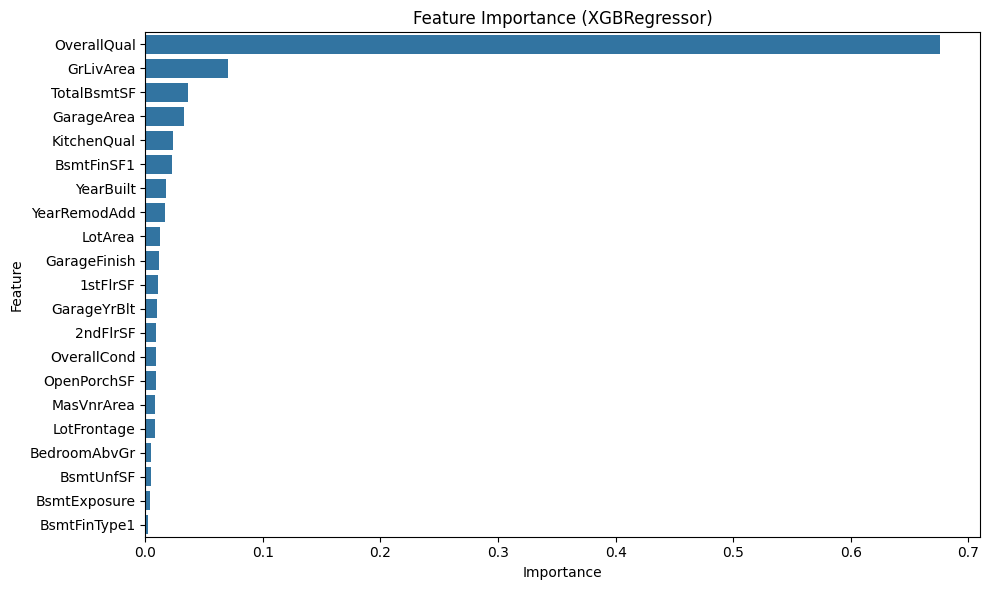

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualize feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importance (XGBRegressor)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

In [24]:
y_train_pred = best_pipeline.predict(X_train)
y_test_pred = best_pipeline.predict(X_test)

In [25]:
import numpy as np

def print_metrics(y_true, y_pred, dataset_name):
    print(f"--- {dataset_name} ---")
    print(f"MAE:  {mean_absolute_error(y_true, y_pred):.2f}")
    print(f"MSE:  {mean_squared_error(y_true, y_pred):.2f}")
    print(f"RMSE: {np.sqrt(mean_squared_error(y_true, y_pred)):.2f}")
    print(f"R²:   {r2_score(y_true, y_pred):.4f}")
    print()

print_metrics(y_train, y_train_pred, "Train Set")
print_metrics(y_test, y_test_pred, "Test Set")


--- Train Set ---
MAE:  9215.18
MSE:  157807008.00
RMSE: 12562.13
R²:   0.9744

--- Test Set ---
MAE:  16772.20
MSE:  714239168.00
RMSE: 26725.25
R²:   0.8966



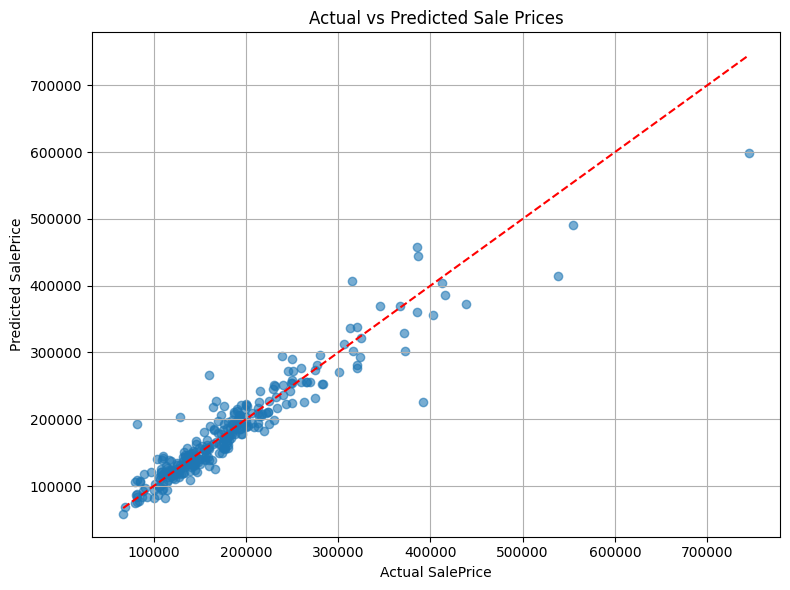

In [26]:
import matplotlib.pyplot as plt

# Scatterplot: Actual vs Predicted
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_test_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r')  # reference line
plt.xlabel('Actual SalePrice')
plt.ylabel('Predicted SalePrice')
plt.title('Actual vs Predicted Sale Prices')
plt.grid(True)
plt.tight_layout()

# Save the plot
plt.savefig('outputs/ml_pipeline/predict_house_price/actual_vs_predicted.png')
plt.show()


## Train the models with the best 6 features

In [40]:

import warnings
# Suppress FutureWarning from pandas for is_categorical_dtype
warnings.filterwarnings(
    "ignore",
    category=FutureWarning,
    message="is_categorical_dtype is deprecated.*",
    module="pandas.*"
)

import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from feature_engine.imputation import MeanMedianImputer, CategoricalImputer, ArbitraryNumberImputer
from feature_engine.encoding import OrdinalEncoder
from feature_engine.transformation import YeoJohnsonTransformer, LogTransformer
from feature_engine.selection import DropFeatures

def create_full_preprocessing_pipeline(model):
    # Custom function to apply square root transformation to specific column
   

    pipeline = Pipeline([
        
        # 2. Drop high-missingness features
        ('drop_features', DropFeatures(features_to_drop=[
            '1stFlrSF', '2ndFlrSF', 'BedroomAbvGr', 'BsmtExposure', 'BsmtFinType1',
            'BsmtUnfSF', 'EnclosedPorch', 'GarageFinish', 'GarageYrBlt',
            'LotArea', 'LotFrontage', 'MasVnrArea', 'OpenPorchSF', 'OverallCond',
            'WoodDeckSF', 'YearBuilt', 'YearRemodAdd'
        ])),
        # 3. Encoding
        ('ordinal_encoder', OrdinalEncoder(
            encoding_method='arbitrary',
            variables=['KitchenQual']
        )),

        # 4. Transformations
        ('yeo_transform', YeoJohnsonTransformer(
            variables=[ 'BsmtFinSF1', 'TotalBsmtSF']  # Removed 'SalePrice'
        )),

        ('log10_transform', LogTransformer(
            base='10',
            variables=['GrLivArea']
        )),

        # 5. Scaling
        ('scaler', StandardScaler()),

        # 6. Estimator
        ('model', model)
    ])

    return pipeline

In [41]:
# Define models (top 3 from previous results)
models_search = {
    'XGBRegressor': XGBRegressor(random_state=42),
}

# Define hyperparameter grids for tuning
params_search = {
    'XGBRegressor': {
        'model__n_estimators': [100],
        'model__learning_rate': [0.05],
        'model__max_depth': [5],
        'model__subsample': [0.8],
    }
}



In [42]:
# Run the search with warning suppression
with warnings.catch_warnings():
    warnings.filterwarnings(
        "ignore",
        category=FutureWarning,
        message="is_categorical_dtype is deprecated.*",
        module="pandas.*"
    )
    search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
    search.fit(X_train, y_train, scoring='r2', n_jobs=-1, cv=5)


Running GridSearchCV for XGBRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


In [43]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary


,estimator,min_score,mean_score,max_score,std_score,model__learning_rate,model__max_depth,model__n_estimators,model__subsample
0,XGBRegressor,0.700824,0.811199,0.878857,0.062991,0.05,5,100,0.8


In [44]:

best_model_with_top_features = grid_search_summary.iloc[0, 0]
best_model_with_top_features


'XGBRegressor'

In [45]:
best_pipeline_with_top_features = grid_search_pipelines[best_model_with_top_features].best_estimator_
best_pipeline_with_top_features

,steps,"[('drop_features', ...), ('ordinal_encoder', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,features_to_drop,"['1stFlrSF', '2ndFlrSF', ...]"
,encoding_method,'arbitrary'
,variables,['KitchenQual']
,missing_values,'raise'
,ignore_format,False
,unseen,'ignore'
,variables,"['BsmtFinSF1', 'TotalBsmtSF']"


In [46]:
import os
import joblib
import json
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Set output path
output_dir = 'outputs/ml_pipeline/predict_house_price/'
os.makedirs(output_dir, exist_ok=True)

# 1. Save trained pipeline
joblib.dump(best_pipeline, os.path.join(output_dir, 'best_pipeline.joblib'))
joblib.dump(best_pipeline_with_top_features, os.path.join(output_dir, 'best_pipeline_with_top_features.joblib'))

# 2. Save best hyperparameters
with open(os.path.join(output_dir, 'best_parameters.json'), 'w') as f:
    json.dump(best_parameters, f, indent=4)

# 3. Save grid search summary
grid_search_summary.to_csv(os.path.join(output_dir, 'grid_search_summary.csv'), index=False)

# 4. Save evaluation results
def get_metrics(y_true, y_pred):
    return {
        "MAE": round(mean_absolute_error(y_true, y_pred), 2),
        "MSE": round(mean_squared_error(y_true, y_pred), 2),
        "RMSE": round(np.sqrt(mean_squared_error(y_true, y_pred)), 2),
        "R2": round(r2_score(y_true, y_pred), 4)
    }

metrics = {
    "train": get_metrics(y_train, best_pipeline.predict(X_train)),
    "test": get_metrics(y_test, best_pipeline.predict(X_test))
}

with open(os.path.join(output_dir, 'evaluation_metrics.json'), 'w') as f:
    json.dump(metrics, f, indent=4)

# 5. Save train/test datasets
X_train.to_csv(os.path.join(output_dir, 'X_train.csv'), index=False)
X_test.to_csv(os.path.join(output_dir, 'X_test.csv'), index=False)
y_train.to_csv(os.path.join(output_dir, 'y_train.csv'), index=False)
y_test.to_csv(os.path.join(output_dir, 'y_test.csv'), index=False)

print(f"✅ All artifacts saved in '{output_dir}'")


✅ All artifacts saved in 'outputs/ml_pipeline/predict_house_price/'
